In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input

print(tf.__version__)

2.8.2


In [4]:
archive_dir = 'drive/MyDrive/Audio/Cat vs Dog/archive/'

dataframe = pd.read_csv(archive_dir+'train_test_split.csv')

dataframe.head()

,Unnamed: 0,test_cat,test_dog,train_cat,train_dog
0,0,cat_22.wav,dog_barking_97.wav,cat_99.wav,dog_barking_33.wav
1,1,cat_116.wav,dog_barking_0.wav,cat_54.wav,dog_barking_86.wav
2,2,cat_155.wav,dog_barking_93.wav,cat_34.wav,dog_barking_45.wav
3,3,cat_58.wav,dog_barking_10.wav,cat_132.wav,dog_barking_76.wav
4,4,cat_77.wav,dog_barking_26.wav,cat_124.wav,dog_barking_4.wav


In [5]:
dog_train_path = os.path.join(archive_dir, 'cats_dogs/train/dog')
cat_train_path = os.path.join(archive_dir, 'cats_dogs/train/cat')

dog_test_path = os.path.join(archive_dir, 'cats_dogs/test/dog')
cat_test_path = os.path.join(archive_dir, 'cats_dogs/test/cat')

In [6]:
train_dog = dataframe[['train_dog']].dropna().rename(index=str, columns={"train_dog": "file"}).assign(label=1)
train_dog

,file,label
0,dog_barking_33.wav,1
1,dog_barking_86.wav,1
2,dog_barking_45.wav,1
3,dog_barking_76.wav,1
4,dog_barking_4.wav,1
...,...,...
59,dog_barking_9.wav,1
60,dog_barking_111.wav,1
61,dog_barking_67.wav,1
62,dog_barking_108.wav,1


In [7]:

train_cat = dataframe[['train_cat']].dropna().rename(index=str, columns={"train_cat": "file"}).assign(label=0)

In [8]:
test_dog = dataframe[["test_dog"]].dropna().rename(index=str, columns={"test_dog":"file"}).assign(label=1)

In [9]:
test_cat = dataframe[["test_cat"]].dropna().rename(index=str, columns={"test_cat": "file"}).assign(label=0)

In [10]:
train_df = pd.concat([train_dog, train_cat]).reset_index(drop=True)

In [11]:
test_df = pd.concat([test_dog, test_cat]).reset_index(drop = True)

In [12]:
train_df.head(300)

,file,label
0,dog_barking_33.wav,1
1,dog_barking_86.wav,1
2,dog_barking_45.wav,1
3,dog_barking_76.wav,1
4,dog_barking_4.wav,1
...,...,...
174,cat_15.wav,0
175,cat_88.wav,0
176,cat_73.wav,0
177,cat_32.wav,0


In [13]:
path = os.path.join(dog_train_path, dataframe['train_dog'][0])
path

'drive/MyDrive/Audio/Cat vs Dog/archive/cats_dogs/train/dog/dog_barking_33.wav'

In [14]:
from IPython.display import Audio
Audio(path)

In [15]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from pydub import AudioSegment

wav_file = AudioSegment.from_file(file=path, format='wav')
print("Data Type %s"%type(wav_file))
print("Frame Rate: %s kHz"% str(int(wav_file.frame_rate) / 1000))
print("Channels: %s"% wav_file.channels)
print("No. of bytes per sample %s bit"% str(wav_file.sample_width * 8))

print("Length %s ms"% len(wav_file))
print("Max Amplitude %d"%wav_file.max)
print("Loudness dBFS: %.2f dB"%wav_file.dBFS)
print("Loudness max dBFS: %.2f dB"%wav_file.max_dBFS)
print("Loudness RMS %d"% wav_file.rms)

samples = np.array(wav_file.get_array_of_samples())
print(samples)

Data Type <class 'pydub.audio_segment.AudioSegment'>
Frame Rate: 16.0 kHz
Channels: 1
No. of bytes per sample 16 bit
Length 3863 ms
Max Amplitude 32736
Loudness dBFS: -20.67 dB
Loudness max dBFS: -0.01 dB
Loudness RMS 3032
[ -1   1   2 ... 114  69  13]


Sample Rate: 16000
Data Array: [ -1   1   2 ... 114  69  13]
[-3.05166468e-05  3.05166468e-05  6.10332937e-05 ...  3.47889774e-03
  2.10564863e-03  3.96716409e-04]


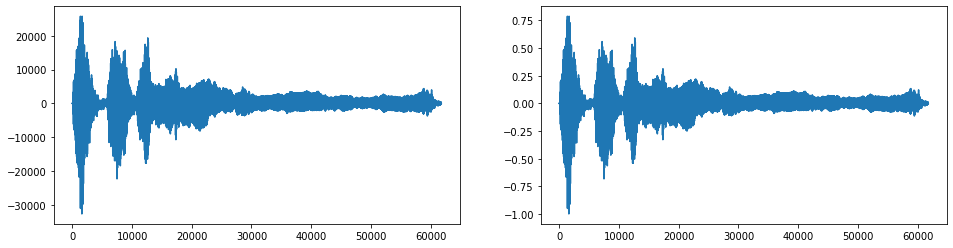

In [17]:
from scipy.io import wavfile

sample_rate, data_arr = wavfile.read(path)
print("Sample Rate: %d"% sample_rate)
print("Data Array:", data_arr)

if data_arr.dtype == 'int16':
  nb_bits = 16
elif data_arr.dtype == 'int32':
  nb_bits = 32

max_nb_bits = float(2 ** (nb_bits - 1))
samples = data_arr / (max_nb_bits + 1)
print(samples)

fix, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(data_arr)
axs[1].plot(samples)

In [18]:
import librosa

y, sr = librosa.load(path, sr = None)
print(y)
print(sr)

[-3.0517578e-05  3.0517578e-05  6.1035156e-05 ...  3.4790039e-03
  2.1057129e-03  3.9672852e-04]
16000


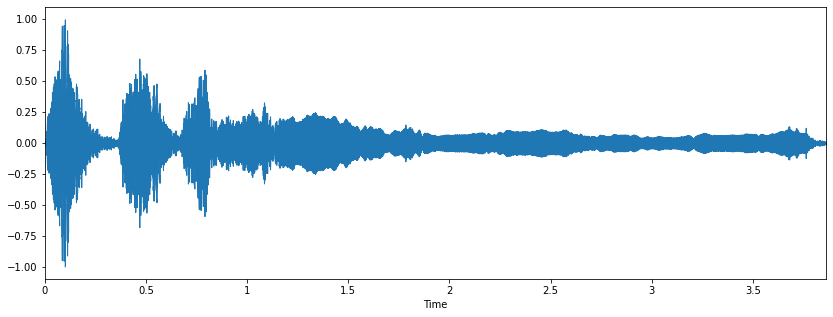

In [19]:
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr = sr)

Create Spectrogram

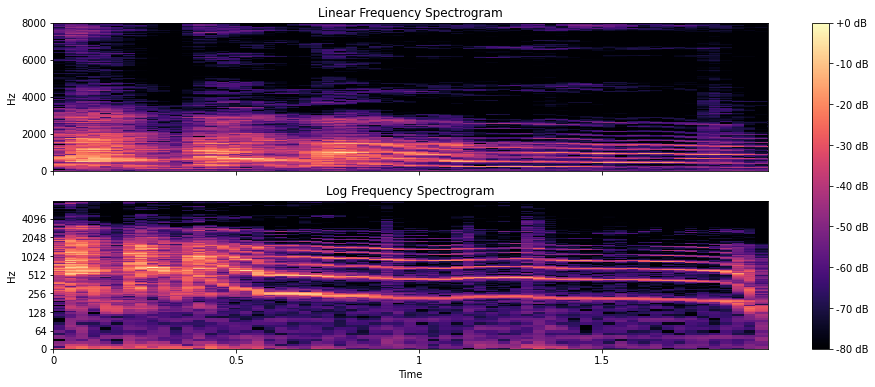

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 6))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=ax[0])
ax[0].set_title("Linear Frequency Spectrogram")
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log", ax=ax[1])
ax[1].set_title("Log Frequency Spectrogram")
ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")

Mel-Frequency Cepstral Coefficients (MFCCs)

(20, 121)


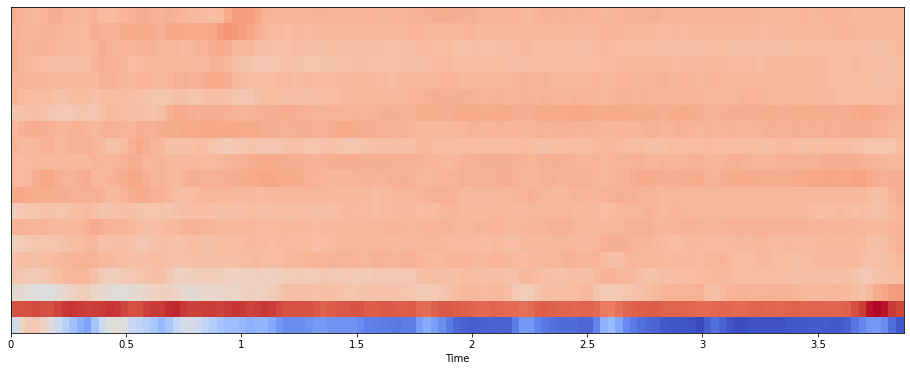

In [21]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print(mfccs.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis = 'time')

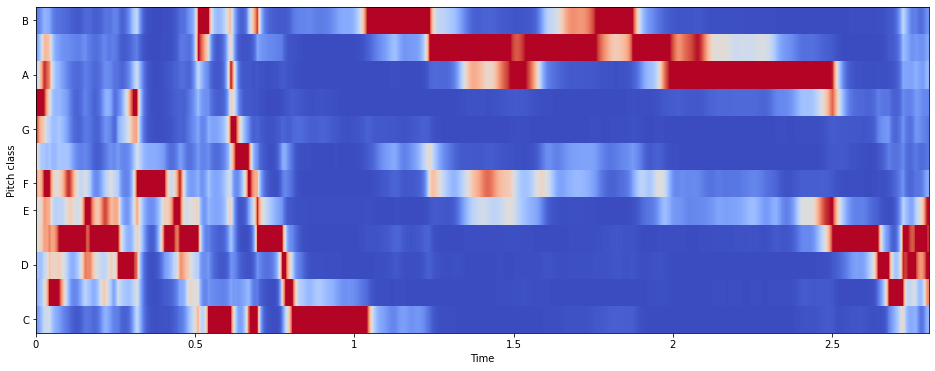

In [22]:
from librosa.feature.spectral import chroma_stft
hop_length = 12
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

Preprocessing

In [23]:
train_dir = os.path.join(archive_dir, 'cats_dogs', 'train')
test_dir = os.path.join(archive_dir, 'cats_dogs', 'test')

In [24]:
file_train = tf.io.gfile.glob(train_dir + '/*/*') # For both subdirectory cat and dog
file_train = tf.random.shuffle(tf.random.shuffle(file_train))

# Training and validation dataset
train_ds = file_train[:165]
val_ds = file_train[165:]
print(train_ds.shape, val_ds.shape)

(165,) (45,)


In [25]:
test_ds = tf.io.gfile.glob(test_dir + '/*/*')
test_ds = tf.random.shuffle(test_ds)
print(test_ds.shape)


(67,)


In [26]:
def get_waveform_label(audio_path):
  label = tf.strings.split(audio_path, os.path.sep)[-2]
  audio_binary = tf.io.read_file(audio_path)
  audio, _ = tf.audio.decode_wav(audio_binary)
  audio = tf.squeeze(audio, axis = -1)
  return audio, label
get_waveform_label(path)

(<tf.Tensor: shape=(61806,), dtype=float32, numpy=
 array([-3.0517578e-05,  3.0517578e-05,  6.1035156e-05, ...,
         3.4790039e-03,  2.1057129e-03,  3.9672852e-04], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTOTUNE)
print(waveform_ds)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


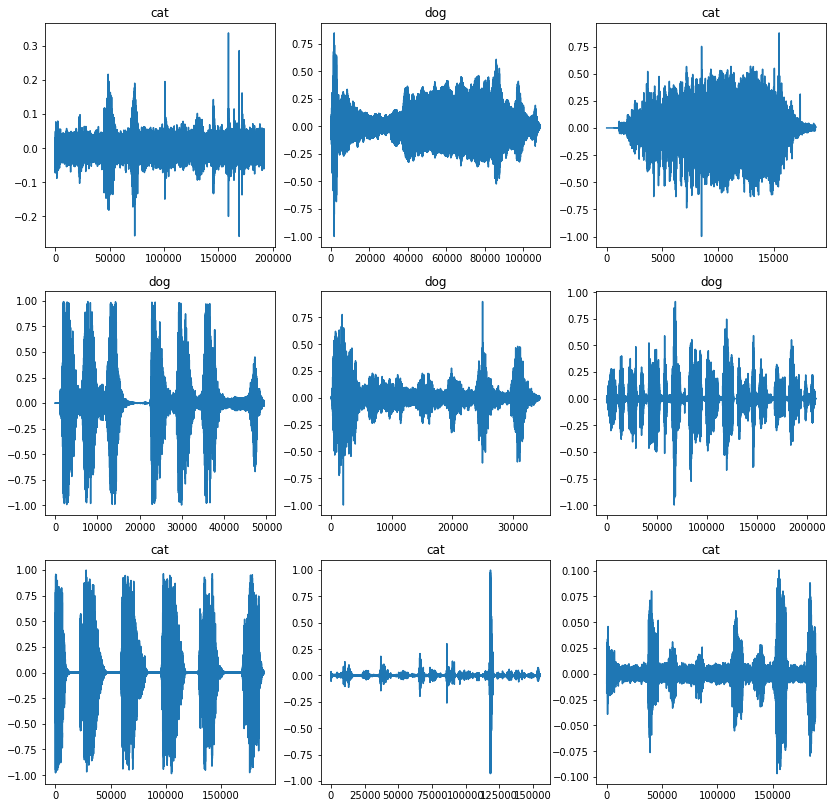

In [28]:
# Plotting
fig, axs = plt.subplots(3, 3, figsize = (14, 14))

for i, (audio, label) in enumerate(waveform_ds.take(9)):
  row = i//3
  col = i%3
  ax = axs[row][col]
  
  ax.plot(audio.numpy())
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

In [29]:
def get_spectrogram_label(audio, label):
  padding = tf.zeros([300000] - tf.shape(audio), dtype = tf.float32)
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(eq_length, frame_length=210, frame_step = 110)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id 


In [30]:
Name = ['cat', 'dog', 'test']
labels = np.array(Name)

spectrogram_ds = waveform_ds.map(get_spectrogram_label, num_parallel_calls=AUTOTUNE)
spectrogram_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [31]:
def plot_spec(spectrogram, ax):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]

  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


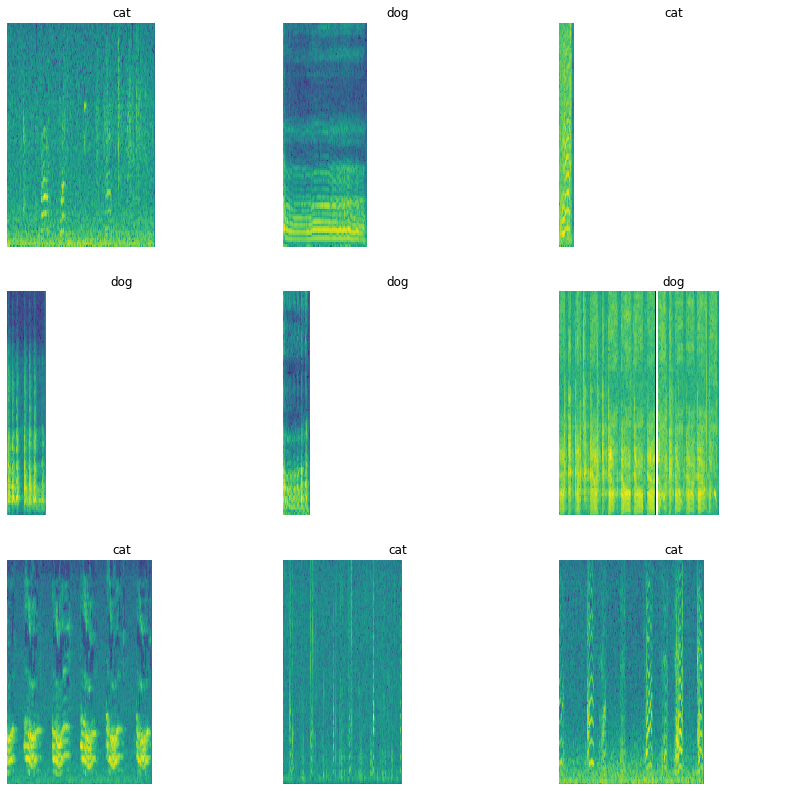

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(14, 14))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(9)):
  row = i//3
  col = i % 3
  ax = axs[row][col]
  plot_spec(np.squeeze(spectrogram), ax)
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')


In [33]:
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_label, num_parallel_calls=AUTOTUNE)
  return output_ds

In [34]:
train_ds = spectrogram_ds
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

In [35]:
BATCH_SIZE = 16
train_ds = train_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [36]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape

num_labels = len(labels)
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

print(input_shape)
print(num_labels)

(2726, 129, 1)
3


Model

In [37]:
from scipy.optimize import optimize
model = Sequential([
    Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Dropout(0.5),
    Conv2D(128, 7, activation='relu'),
    Conv2D(256, 7, activation='relu'),
    MaxPool2D(),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(num_labels)
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [38]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds)


Epoch 1/30
11/11 [==============================] - 10s 873ms/step - loss: 5.1609 - accuracy: 0.4242 - val_loss: 3.8001 - val_accuracy: 0.3333
Epoch 2/30
11/11 [==============================] - 2s 157ms/step - loss: 3.8748 - accuracy: 0.4242 - val_loss: 0.9001 - val_accuracy: 0.5556
Epoch 3/30
11/11 [==============================] - 2s 158ms/step - loss: 1.6541 - accuracy: 0.3939 - val_loss: 0.7847 - val_accuracy: 0.6889
Epoch 4/30
11/11 [==============================] - 2s 161ms/step - loss: 0.9186 - accuracy: 0.3333 - val_loss: 0.8732 - val_accuracy: 0.5333
Epoch 5/30
11/11 [==============================] - 2s 156ms/step - loss: 1.0271 - accuracy: 0.3394 - val_loss: 0.8688 - val_accuracy: 0.2667
Epoch 6/30
11/11 [==============================] - 2s 158ms/step - loss: 0.8298 - accuracy: 0.2606 - val_loss: 0.7615 - val_accuracy: 0.0000e+00
Epoch 7/30
11/11 [==============================] - 2s 160ms/step - loss: 0.7237 - accuracy: 0.1939 - val_loss: 0.7584 - val_accuracy: 0.0444
E

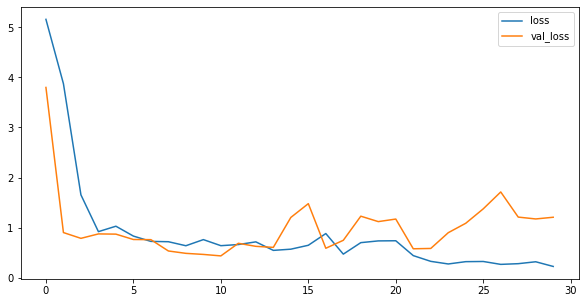

In [39]:
fig, axs = plt.subplots(figsize = (10, 5))

plt.plot(history.epoch, history.history['loss'], history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

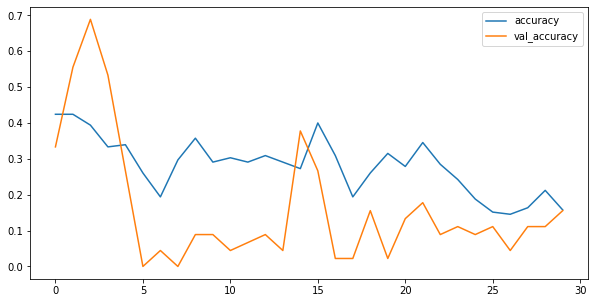

In [40]:
fig, axs = plt.subplots(figsize = (10, 5))

plt.plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [43]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

test_labels

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1])

In [46]:
for audio, label in test_ds:
  print(label)

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

In [47]:
y_pred = np.argmax(model.predict(test_audio), axis = 1)
print(y_pred)

[2 0 1 2 1 1 2 2 2 1 2 1 1 0 1 2 2 2 0 2 1 1 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 2 1 2 2 2 2 2 0 2 2 1 1 2 1 2 1 2 2 2 2 2 2 1]


In [48]:
t_labels = []
pred_labels = []

for item in test_labels:
  if item == 2:
    t_labels+=[1]
  else:
    t_labels+=[0]

for item in y_pred:
  if item == 2:
    pred_labels+=[1]
  else:
    pred_labels+=[item]

y_true = np.array(t_labels)
y_pred = np.array(pred_labels)

print(y_pred)

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [49]:
test_acc = sum(y_pred == y_true) / len(y_true)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.05970149253731343


In [50]:
from sklearn.metrics import classification_report, log_loss, accuracy_score

print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.06      1.00      0.11         4
           1       0.00      0.00      0.00        63

    accuracy                           0.06        67
   macro avg       0.03      0.50      0.06        67
weighted avg       0.00      0.06      0.01        67



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 33.0, 'Predicted label')

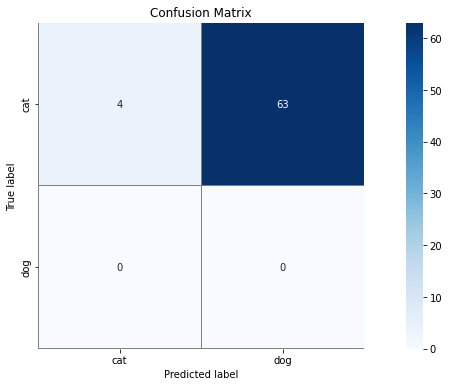

In [51]:
cm = tf.math.confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(cm, xticklabels=Name[:2], yticklabels=Name[:2], annot=True, 
            cmap='Blues', square=True, linewidths=0.01, linecolor='grey')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

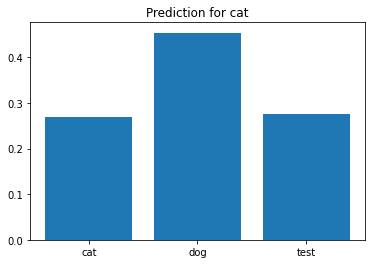

In [70]:
sample_file = os.path.join(archive_dir, 'cats_dogs', 'cat_1.wav')

sample_ds = preprocess([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(Name, tf.nn.softmax(prediction[0]))
  plt.title('Prediction for '+str(Name[label.numpy()[0]]))